# Introduction

In this notebook, we will walk through how to construct a Markov State Model and use it to identify the metastable ligand binding modes in an MD simulation via the tools provided from PyEMMA. We will apply this to the toluene bound to T4 lysozyme case, highlighted in the [BLUES](https://chemrxiv.org/articles/Binding_Modes_of_Ligands_Using_Enhanced_Sampling_BLUES_Rapid_Decorrelation_of_Ligand_Binding_Modes_Using_Nonequilibrium_Candidate_Monte_Carlo/5406907/4) paper. For specific details see section 2.4 in the paper.

*Note: Since we are using only a single (unconverged) trajectory as an example, the parameters may not reflect the true answers.*

# Requirements

Add the conda-forge software channel, and install (or update) PyEMMA:
```bash
conda config --add channels conda-forge
conda install pyemma
```

# Featurization

Import the [pyEMMA coordinates](http://emma-project.org/latest/api/index_coor.html).
>  This package contains functions and classes for reading and writing trajectory files, extracting order parameters from them (such as distances or angles), as well as various methods for dimensionality reduction and clustering.

In [1]:
import pyemma.coordinates as coor
import numpy as np
from blues import utils #Use this to get the test data

In [2]:
#Define our input MD files
trajfiles = utils.get_data_filename('blues.analysis', 'tests/data/run03-centered.dcd')
pdbfile = utils.get_data_filename('blues.analysis', 'tests/data/run03-centered.pdb')

From the coordinates module, use the [featurizer](http://emma-project.org/latest/api/generated/pyemma.coordinates.featurizer.html#pyemma.coordinates.featurizer) to generate the pairwise-distances of the toluene heavy-atoms and the alpha carbons of the binding site.

In [3]:
feat = coor.featurizer(pdbfile)

atom_index = np.array([2634, 2635, 2636, 2637, 2638, 2639, 2640, 
                       1605, 1622, 1638, 1658, 1675, 1692, 
                       1700, 1714, 1728, 1735, 1751, 1761, 1768, 1788])
paired_index = feat.pairs(atom_index)

In [4]:
feat.add_distances(paired_index)
inp = coor.source(trajfiles, feat)

# Constructing the Markov State Model

#### Theory: 
- [Implied timescales](http://docs.markovmodel.org/lecture_implied_timescales.html)
- Pande, V. S., K. A. Beauchamp, and G. R. Bowman. [Everything you wanted to know about Markov State Models but were afraid to ask](http://www.sciencedirect.com/science/article/pii/S1046202310001568?via%3Dihub)
 Methods 52.1 (2010): 99-105
Let's estimate MSMs at different lagtimes. Now we would like the lagtime to converge within the statistical uncertainty.

In the BLUES repository, there is an analysis module that carries the python class `ConstructMSM()` which provides convenience functions for using PyEMMA. Let's import that below and initialize the class by providing it the `FeatureReader` that we have stored in the `inp` variable above.

In [5]:
from blues.analysis import msm

In [6]:
#This will load the trajectory data into memory.
data = msm.ConstructMSM(inp)

number of trajectories =  1
number of dimension =  210


A Jupyter Widget

In [7]:
#The featurized data can be accessed in the attribute Y.
data.Y

[array([[ 0.13885608,  0.13722233,  0.2412592 , ...,  0.39282653,
          0.54579854,  0.3880012 ],
        [ 0.13394438,  0.14077201,  0.23612934, ...,  0.39263985,
          0.54982346,  0.38299057],
        [ 0.13788714,  0.13847092,  0.23423693, ...,  0.38993716,
          0.56850046,  0.37955016],
        ..., 
        [ 0.14443384,  0.14125474,  0.24468331, ...,  0.37705451,
          0.5515669 ,  0.3866497 ],
        [ 0.14126575,  0.1391048 ,  0.24421905, ...,  0.3788586 ,
          0.54252064,  0.37997493],
        [ 0.13704751,  0.1417391 ,  0.23734583, ...,  0.38931   ,
          0.57324731,  0.39259216]], dtype=float32)]


# Dimensionality Reduction with TICA
As indicated above, there are 210 dimensions from using the pairwise distances as out feature space. To reduce the number of dimensions in our feature space, we turn to a method known as TICA, which will essentially give use the maximimally slow coorindates to help us in finding the metastable ligand binding modes. Additionally, we will need to find a suitable lag time to discretize our data for MSM construction.

#### Theory
- [time-lagged independent component analysis (TICA)](http://docs.markovmodel.org/lecture_tica.html)

Run TICA for a series of lag times and select a suitable lag time for further analysis. In order to do so, have a look at the implied timescales generated by TICA. The [TICA object](http://emma-project.org/latest/api/generated/pyemma.coordinates.tica.html#pyemma.coordinates.tica) has an attribute timescales.



In [8]:
#Frames in MD simulation were taken every 30ps 
dt = 30
lag_list = np.arange(1, 16,5)

We provide a conveience function for plotting the implied timescales from TICA. Simply provide the following inputs to `plotImpliedTimescales()`:
- inp : Featurized coordinate data
- dt  : int() timestep interval from trajectory frames
- lag_list : list of lag times to try
- outfname : str() specifying the output filename. None displays plot.

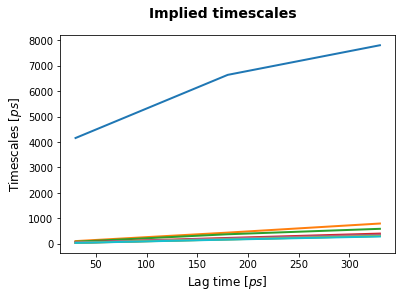

In [9]:
data.plotImpliedTimescales(data.Y, dt, lag_list)

From the plot above, it looks like we should expect to see two states at timescales above 4000ps. It appears any of these lagtimes will separate our data into two states. Let's discretize our data using k-means clustering and construct our MSM using a lagtime of 200 (but any of these will work).

In [10]:
#This convenience function will perform: 
# TICA, k-means clustering, and estmate the MSM
data.getMSM(data.Y, dt, lagtime=200,fixed_seed=1);

TICA dimension  54
23-01-18 15:40:38 pyemma.coordinates.clustering.kmeans.KmeansClustering[10] INFO     The number of cluster centers was not specified, using min(sqrt(N), 5000)=44 as n_clusters.


A Jupyter Widget

A Jupyter Widget

23-01-18 15:40:38 pyemma.coordinates.clustering.kmeans.KmeansClustering[10] INFO     Cluster centers converged after 19 steps.


In [11]:
#The MSM object for PyEMMA can be accessed like:
data.M;

The discretized trajectory information can be accessed from the following properties:
- dtrajs : list of arrays, each array contains the trajectory frames assigned to the cluster centers indices.
- centers : numpy array, contains the coordinates of the cluster       centers
- index_clusters : list of arrays, For each state, all trajectory and    time indexes where this cluster occurs. Each row consists of a pair [i,t], where `i` is the index of the trajectory and `t` is the frame index.


In [12]:
#The discretized trajectory information can be accessed like:
data.dtrajs; data.centers; data.index_clusters;

# Clustering the data

Now, that we've constructed our MSM and discretized the trajectory data by TICA-transforming our feature space. Let's move on to finding the metastable ligand binding modes by assigning our discretized trajectories to metastable states determined by [PCCA++](http://www.emma-project.org/v2.4/api/generated/pyemma.msm.PCCA.html).

#### Theory
- [PCCA: perron-cluster cluster analysis](http://docs.markovmodel.org/lecture_pcca.html)
- [Silhouettes: A graphical aid to the interpretation and validation of cluster analysis](https://www.sciencedirect.com/science/article/pii/0377042787901257)

Let's import the `cluster` module and initialize the `FindBindingModes` class by providing the MSM data we computed from the last section.


In [13]:
from blues.analysis import cluster

In [14]:
fbm = cluster.FindBindingModes(data)

PCCA++ requires that we provide the number of clusters to assign the trajectory data to. From our implied timescales plot, we expect to see two states. But, what if we do not know how many states beforehand?

The function `getNumBindingModes` will try a range of different cluster numbers for PCCA++ and score the assignments by [Silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. 

	For n_clusters = 2 The average silhouette_score is : 0.636107
	For n_clusters = 3 The average silhouette_score is : 0.520404
	For n_clusters = 4 The average silhouette_score is : 0.578263
	Initial suggestion n_clusters = 2
	Checking if n_clusters = 4 is within error.
Suggested number of cluster = 2


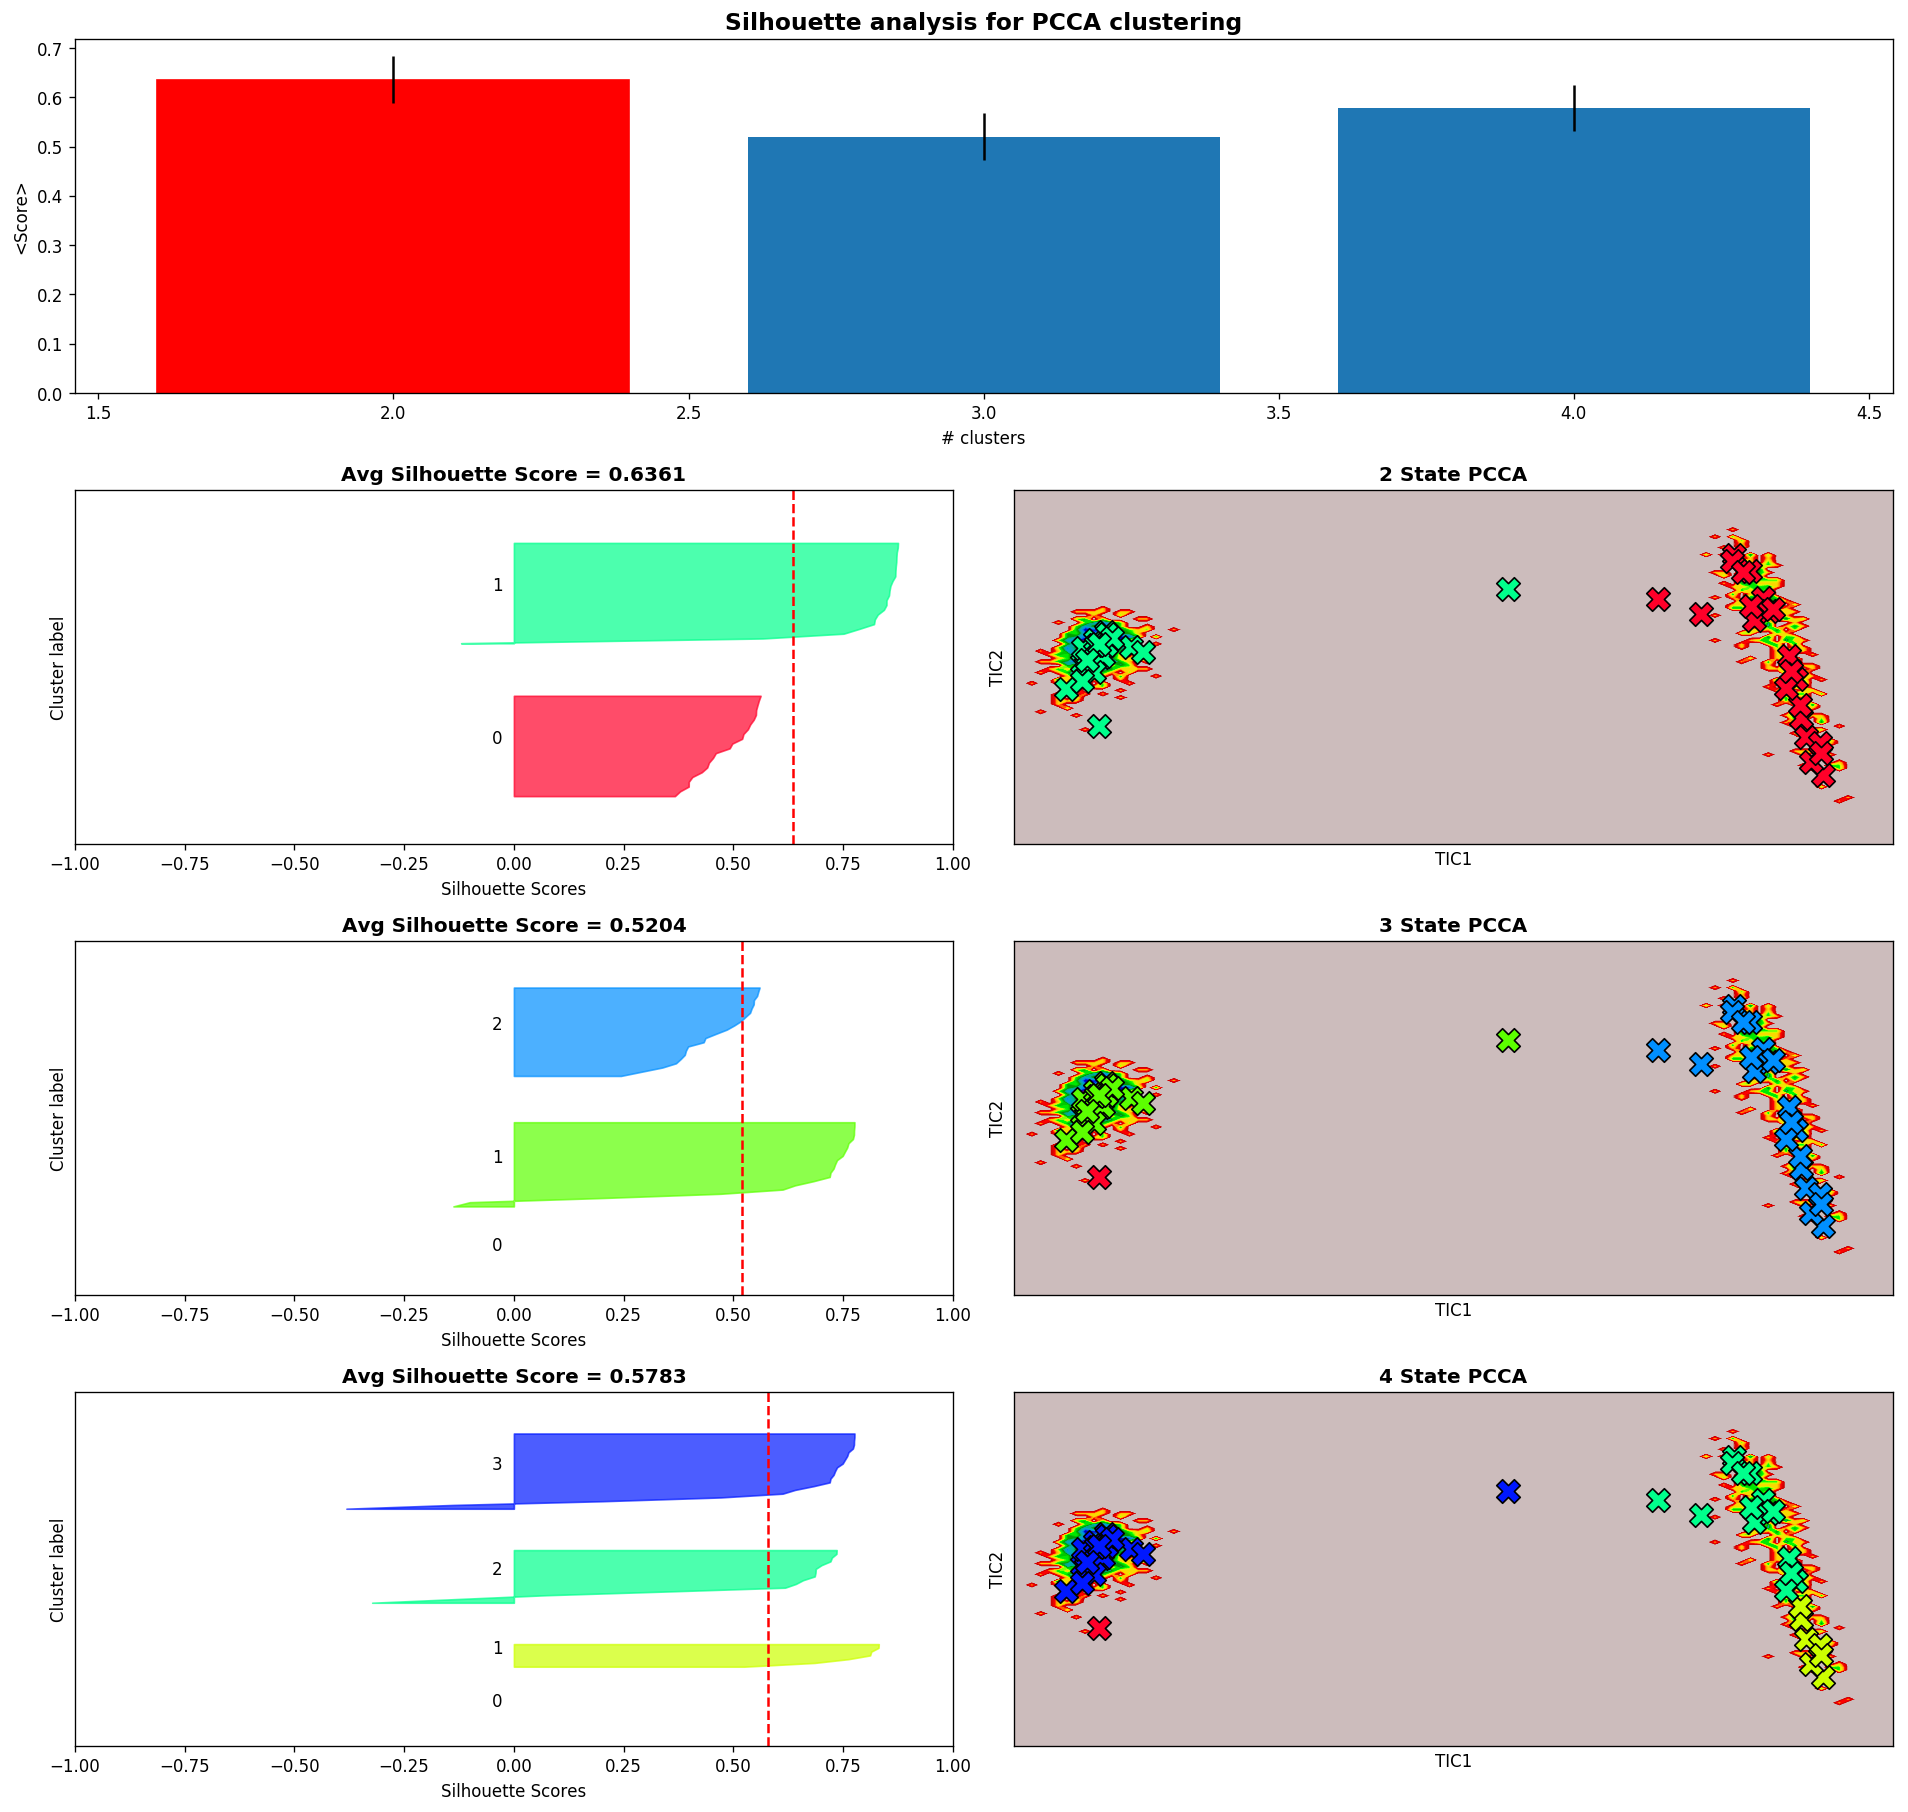

In [15]:
#Get the optimimal number of clusters by silhouette score
# We can provide how many samples to store for each PCCA cluster here.
n_clusters = fbm.getNumBindingModes(range_n_clusters=range(2,5),
                                   n_samples=100)

The silhouette analysis confirms that we should expect two meatstable states in our given trajectory. 

We can save samples from each cluster according to the PCCA++ membership probabilities. We can do that using the function `savePCCASamples()` below:

In [16]:
#Draw samples from the PCCA metastable distributions
# Save them to separate files
pcca_outfiles = fbm.savePCCASamples(n_clusters, outfname='t4-tol')

Storing [100] PCCA samples each to: 
	t4-tol-pcca0_samples.dcd
	t4-tol-pcca1_samples.dcd


If we visualize the files in VMD, you should generally see the two binding modes like below:
![Toluene-BindingModes](t4-tol-leaders.png)

# Calculating binding mode populations

Now that we have defined what our stable ligand binding modes are, we can calculate the occupancy of each of the two binding modes using the `population` module.

Before we initialize `BindingModeOccupancy` we will need a couple of input parameters:


- molid : str, specifying the name of the molecule
- trajfile : str, specifying the path for a single trajectory file to analyze.
- tica_coord : numpy array, tica coordinates for the associated trajectory.
- time_per_frame: float, time in nanoseconds per trajectory frame.
- sel : str, selection str for computing the RMSD. Default = 'resname LIG and not type H' to compute the ligand heavy atom RMSD.
```


the  class with the path of the single trajectory file you wish to analyze.

In [17]:
from blues.analysis import population

In [18]:
bmo = population.BindingModeOccupancy(molid='t4-tol',
                            trajfile=trajfiles,
                            tica_coord=fbm.data.tica_coordinates[0],
                            time_per_frame=0.03)

Analyzing populations in /home/nathanlim/anaconda3/envs/bluesdev/lib/python3.5/site-packages/blues-0.1.3-py3.5.egg/blues/analysis/tests/data/run03-centered.dcd


We can plot and calculate the occupancy using the `calcOccupancy` function.
```
Assigns the trajectory frames to a given cluster by minimizing the euclidean distance (in TICA space) to the centers from PCCA. Plots the RMSD of the ligand, relative to the starting position, coloring each datapoint to it's assigned cluster and calculates the occupancy of each ligand binding mode.
```

This function requires two inputs obtained from doing PCCA:
- pcca_centers : numpy array, contains the coordinates of the cluster centers from the active set states obtained from PCCA.
- pcca_labels : list, cluster assignment of the centers from PCCA.

We can access the PCCA data stored in a dictionary from the `FindBindingModes` object

In [19]:
pcca_centers = fbm.silhouette_pcca[n_clusters]['Centers']
pcca_labels = fbm.silhouette_pcca[n_clusters]['Labels']

	Total num BM changes: 6


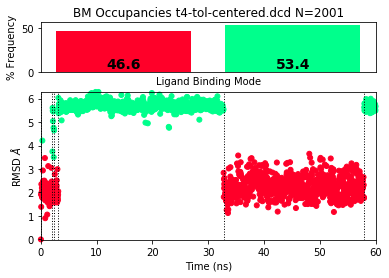

In [20]:
bmo.calcOccupancy(pcca_centers, pcca_labels)